In [20]:
import os, sys
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../modules')
from ar_scale import calc_ar_scale

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'

In [3]:
fname_pattern = path_to_data + 'preprocessed/ARScale_ERA5/ERA5_ARScale_*.nc'
filenames = glob.glob(fname_pattern)
filenames

['/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2021.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2019.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2018.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2020.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2022.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2023.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2008.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2009.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2003.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2014.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2015.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2002.nc',
 '/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2000.nc',
 '/expanse/n

In [ ]:
%%time
lat = 59.
lon = -135.5
df_lst = []
for i, fname in enumerate(filenames):
    ds = xr.open_dataset(fname)
    ds = ds.sel(lat=lat, lon=lon)
    df = ds['IVT'].to_dataframe()
    df_lst.append(df)

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [ ]:
df_lst[0]

In [7]:
ds = xr.concat(ds_lst, dim='time')
ds

KeyboardInterrupt: 

In [5]:
## add water year to data as coordinate
water_year = (ds.time.dt.month >= 10) + ds.time.dt.year
ds.coords['water_year'] = water_year

In [6]:
df = ds.IVT.to_dataframe()
df


KeyboardInterrupt



In [ ]:
ds

In [ ]:
ct_lst = []
arscale_lst = []
for i, arscale_val in enumerate(arscale_lst):
    tmp = ds.where(ds.rank == arscale_val, drop=True)
    ct = tmp['rank'].groupby(tmp.water_year).count(dim="time")
    ct_lst.append(ct)

In [7]:
era

<xarray.Dataset>
Dimensions:  (time: 720, lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 2020-11-01 ... 2020-11-30T23:00:00
Data variables:
    IVT      (time, lat, lon) float64 dask.array<chunksize=(720, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1/0
    history:      Mon Apr  8 12:54:40 2024: ncks -v IVT -O --mk_rec_dmn time ...
    NCO:          netCDF Operators version 5.2.2 (Homepage = http://nco.sf.ne...

In [10]:
dates

DatetimeIndex(['2020-11-30'], dtype='datetime64[ns]', freq='M')

In [15]:
start_date='2020-11-01'
end_date='2020-12-05'
lat = 59.
lon = -135.5
y = lat
x = lon

dates = pd.date_range(start=start_date, end=end_date, freq='1MS')
# put into pandas df
d ={"date": dates}
df = pd.DataFrame(data=d)
df['month']= df['date'].dt.month.map("{:02}".format)
df['year']= df['date'].dt.year

# create list of daily ERA5 files for each AR
filenames = []
for j, row in df.iterrows():
    filenames.append('/expanse/nfs/cw3e/cwp140/preprocessed/ERA5/ivt/{0}{1}_IVT.nc'.format(row['year'], row['month']))
    # open all files within the AR period
print(filenames)
era = xr.open_mfdataset(filenames, combine='by_coords', parallel=False)

ds = era.sel(lat=y, lon=x, method='nearest')
df = ds.to_dataframe()
start_date='2020-11-27'
end_date='2020-12-05'
idx = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[idx]
df

['/expanse/nfs/cw3e/cwp140/preprocessed/ERA5/ivt/202011_IVT.nc', '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5/ivt/202012_IVT.nc']


,IVT,lat,lon
time,,,
2020-11-27 00:00:00,44.803837,59.0,-135.5
2020-11-27 01:00:00,48.235082,59.0,-135.5
2020-11-27 02:00:00,46.860642,59.0,-135.5
2020-11-27 03:00:00,45.855399,59.0,-135.5
2020-11-27 04:00:00,42.403127,59.0,-135.5
...,...,...,...
2020-12-04 20:00:00,189.695112,59.0,-135.5
2020-12-04 21:00:00,195.893712,59.0,-135.5
2020-12-04 22:00:00,181.768193,59.0,-135.5


In [16]:
### Get x-tick and x-labels for both cases
x1 = df.index.values

x_lst = [x1]
xlbl_lst = []
xtick_lst = []
for i, x in enumerate(x_lst):
    x_lbl = []
    xtick_lst.append(x)
    for j in range(len(x)):
        t = pd.to_datetime(str(x[j]))
        x_lbl.append(t.strftime('%m-%d'))
    xlbl_lst.append(x_lbl)

In [17]:
df = df.reset_index()
df = df.rename(columns={"time": "date"})
ar_scale = calc_ar_scale(df)
ar_scale

,start_date,end_date,duration,max_IVT,AR_scale
1,2020-12-01 06:00:00,2020-12-03 05:00:00,47.0,522.499995,2


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/scratch/dnash/job_33406387/ipykernel_86554/3428571716.py:9: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('IVT $\mathrm{(kg \: m^{-1} \: s^{-1})}$', fontsize=10.)


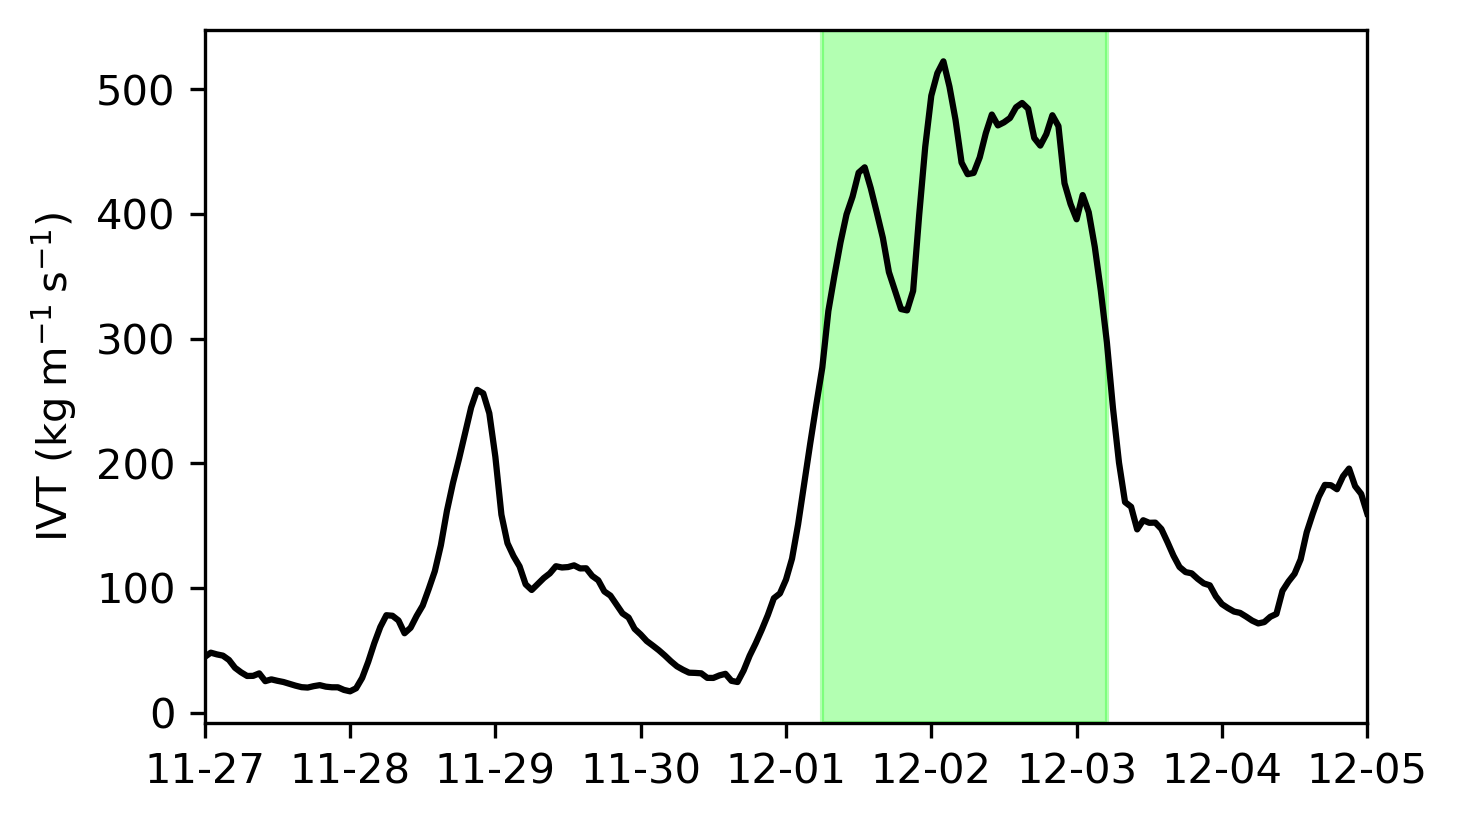

In [22]:
fname = '../figs/ar_tseries_dec2019'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((5.0,3.0))
fig.dpi = 300

ax = fig.add_subplot(1, 1, 1)
ax.plot(x1, df.IVT.values, color='k')
ax.set_ylabel('IVT $\mathrm{(kg \: m^{-1} \: s^{-1})}$', fontsize=10.)
ax.set_xlim(x1.min(), x1[-24])

## x-axis format dates/ticks
x_ticks = xtick_lst[0]
x_labels = xlbl_lst[0]
ax.set_xticks(x_ticks[::24]) # set the labels every x hours
ax.set_xticklabels(x_labels[::24], fontsize=10)

# highlight a time range
for index, row in ar_scale.iterrows():
    if row['AR_scale'] == 1:
        c = (10./255.0, 193./255.0, 255./255.0) #10, 193, 255
    elif row['AR_scale'] == 2:
        c = (4./255.0, 255./255.0, 3./255.0) #4, 255, 3
    elif row['AR_scale'] == 3:
        c = (255./255.0, 255./255.0, 3./255.0) #255, 255, 3
    elif row['AR_scale'] == 4:
        c = (255./255.0, 166./255.0, 2./255.0) #255, 166, 2
    elif row['AR_scale'] == 5:
        c = (255./255.0, 1./255.0, 0./255.0) #255, 1, 0
        

    ax.axvspan(row['start_date'], row['end_date'], color=c, alpha=0.3)
    
# ## add twin axis for SWE
# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.bar(x1[::24], SWE, color='tab:blue', alpha=0.5, zorder=0)
# ax2.set_ylabel('SWE (inches)', fontsize=10., color='tab:blue')    
    
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()